## 零、載入套件

In [2]:
import os
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from datetime import datetime
import matplotlib.pyplot as plt

plt.rc('font', family='Microsoft JhengHei')
plt.rcParams['axes.unicode_minus'] = False

## 一、匯入資料

- 下載 113 年第一季到 114 年第一季資料。
- 資料夾命名為 113S1 ~ 114S1 ，個別從資料夾讀取台北市和新北市檔案('A_lvr_land_C.csv', 'F_lvr_land_C.csv')

In [3]:
dfs_realEstate = []
folders =  [d for d in os.listdir() if os.path.isdir(os.path.join(d)) and d[0] == '1']

for d in folders:    
    # 匯入台北市不動產 CSV 檔案
    df_realEstate_a = pd.read_csv(os.path.join(d,'A_lvr_land_C.csv'), 
                                  index_col=False,                    # 不要將CSV檔案中的任何一列作為索引，而是使用默認的整數索引
                                  quoting=csv.QUOTE_NONE)             # 不要處理引號
    df_realEstate_a['縣市'] = '台北市'
    df_realEstate_a['季別'] = d
    dfs_realEstate.append(df_realEstate_a.iloc[1:])                   # 排除第 0 列：英文欄位名稱
    
    # 匯入新北市不動產 CSV 檔案
    df_realEstate_f = pd.read_csv(os.path.join(d,'F_lvr_land_C.csv'), index_col = False, quoting = csv.QUOTE_NONE) 
    df_realEstate_f['縣市'] = '新北市'
    df_realEstate_f['季別'] = d
    dfs_realEstate.append(df_realEstate_f.iloc[1:])  

# 合併雙北不動產資訊
df_realEstate = pd.concat(dfs_realEstate)   
pd.set_option('display.max_columns', None) # 顯示所有欄位
df_realEstate.head(1)

,鄉鎮市區,交易標的,土地位置建物門牌,土地面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,租賃年月日,租賃筆棟數,租賃層次,總樓層數,建物型態,主要用途,主要建材,建築完成年月,建物總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,有無附傢俱,總額元,單價元平方公尺,車位類別,車位面積平方公尺,車位總額元,備註,編號,出租型態,有無管理員,租賃期間,有無電梯,附屬設備,租賃住宅服務,縣市,季別
1,中正區,租賃房屋,臺北市中正區和平西路一段５５巷２０號６樓,0.0,NaN,NaN,NaN,1121018,土地0建物1車位0,六層,7,華廈(10層含以下有電梯),住家用,鋼筋混凝土造,0990903,121.69999999999999,2,2,2,有,有,有,59000,485,NaN,0.0,0,租金總額含管理費；續租案件；,RPPNMLLKJIIGFAA66CC,整棟(戶)出租,有,1121018~1141017,有,冷氣、熱水器、洗衣機、電視機、冰箱、瓦斯或天然氣、網路,NaN,台北市,113S1


In [4]:
print(df_realEstate.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 48046 entries, 1 to 617
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   鄉鎮市區       48046 non-null  object
 1   交易標的       48046 non-null  object
 2   土地位置建物門牌   48046 non-null  object
 3   土地面積平方公尺   48046 non-null  object
 4   都市土地使用分區   3373 non-null   object
 5   非都市土地使用分區  62 non-null     object
 6   非都市土地使用編定  62 non-null     object
 7   租賃年月日      48046 non-null  object
 8   租賃筆棟數      48046 non-null  object
 9   租賃層次       47825 non-null  object
 10  總樓層數       47874 non-null  object
 11  建物型態       48046 non-null  object
 12  主要用途       46606 non-null  object
 13  主要建材       47857 non-null  object
 14  建築完成年月     45301 non-null  object
 15  建物總面積平方公尺  48046 non-null  object
 16  建物現況格局-房   48046 non-null  object
 17  建物現況格局-廳   48046 non-null  object
 18  建物現況格局-衛   48046 non-null  object
 19  建物現況格局-隔間  48046 non-null  object
 20  有無管理組織     48046 non-null  object
 

## 二、資料處理

### 1. 建物型態 & 主要用途

我們考慮類似的房型來比較。透過以下限制來進行篩選，以便進行房價預測：
- 在建物型態考慮：'住宅大樓(11層含以上有電梯)'、'公寓(5樓含以下無電梯)'、'華廈(10層含以下有電梯)'、'套房(1房1廳1衛)'
- 在主要用途考慮：'住家用'、'住宅'等字眼。

In [5]:
print('建物型態:\n',df_realEstate['建物型態'].unique())
print('主要用途:\n',df_realEstate['主要用途'].unique())

建物型態:
 ['華廈(10層含以下有電梯)' '住宅大樓(11層含以上有電梯)' '廠辦' '辦公商業大樓' '公寓(5樓含以下無電梯)' '透天厝'
 '店面(店鋪)' '其他' '套房(1房1廳1衛)' '工廠' '倉庫' '農舍']
主要用途:
 ['住家用' '一般事務所（Ｇ－２）' '商業用' '集合住宅' '自由業事務所' '工業用' '多戶住宅' '一般事務所'
 '策略性產業（資訊服務業）' '住工用' '住商用' '一般零售業甲組' '見使用執照' '（Ｈ２）集合住宅' nan
 '策略性產業〈資訊服務業〉' '（第二組）多戶住宅（集合住宅）（Ｈ２）' '（Ｈ２）住宅' '一般事務所、一般辦公室'
 '一般服務業〈職業介紹所〉' '一般零售業甲組（不含日用百貨）' '多戶住宅（Ｈ２）（２組）' '策略性產業（產品展示服務業）２７組（Ｇ２）'
 '辦公室' '公害輕微之工業【廠房﹝不含液化石油氣、汽車改裝業及汽車修理〈甲種汽車修理廠〉業﹞】' '資訊軟體服務業之資訊軟體國際貿易，批發'
 'Ｇ２一般事務所兼金融保險業Ｇ１' '醫療保健服務業（藥局）' '策略性產業' '一般事務所，供商談、接洽、處理一般事務之場所'
 '店舖、辦公室、防空避難室' '金融保險業兼餐飲業' '多戶住宅、住宅' '自由職業事務所' '一般零售業' '（第二組）多戶住宅（Ｈ２）'
 '停車空間' '策略性產業（資訊服務業）一般辦公室' '第２８類組一般事務所（Ｇ２）兼第３０類組金融保險業（Ｇ１）' '員工宿舍'
 '集合住宅，多戶住宅' '多戶住宅（第二組）（Ｈ２）' '集合住宅、多戶住宅'
 '第２８類組一般事務所（Ｇ２）、第３０類組金融保險業（Ｇ１）、第３３類組健身服務業（Ｄ１）' '多戶住宅（Ｈ２）' '一層：店舖，二至六層：住宅'
 '一般零售業甲組（不包括日用百貨）' '店鋪、集合住宅' '一般事務所（Ｇ３）' '策略性產業（Ｇ２）' '策略性產業（第２７組產品展示服務業）'
 '日常用品零售業' '策略性產業（供第一目資訊服務業使用）' '國民住宅' '一般零售業甲、乙組（Ｇ２）（日用百貨除外、不含便利商店）'
 '辦公室、停車場' '一般事務所（Ｇ２）' '集合住宅第二組：多戶住宅' '資訊服務業' '辦公廳' '一般零售業甲組（Ｇ３）（日用百貨除外）'
 

In [6]:
# 選擇特定的建物型態和主要用途並進行過濾
specific_building_types = ['住宅大樓(11層含以上有電梯)', '公寓(5樓含以下無電梯)', '華廈(10層含以下有電梯)', '套房(1房1廳1衛)']
specific_main_usage = ['住家|住宅']

df_realEstate1 = df_realEstate[  df_realEstate['建物型態'].isin(specific_building_types) 
                               & df_realEstate['主要用途'].str.contains('住家|住宅', na=False)]

df_realEstate1.reset_index(drop=True, inplace=True) 
print(df_realEstate1.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37636 entries, 0 to 37635
Data columns (total 37 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   鄉鎮市區       37636 non-null  object
 1   交易標的       37636 non-null  object
 2   土地位置建物門牌   37636 non-null  object
 3   土地面積平方公尺   37636 non-null  object
 4   都市土地使用分區   2250 non-null   object
 5   非都市土地使用分區  27 non-null     object
 6   非都市土地使用編定  27 non-null     object
 7   租賃年月日      37636 non-null  object
 8   租賃筆棟數      37636 non-null  object
 9   租賃層次       37636 non-null  object
 10  總樓層數       37636 non-null  object
 11  建物型態       37636 non-null  object
 12  主要用途       37636 non-null  object
 13  主要建材       37619 non-null  object
 14  建築完成年月     36333 non-null  object
 15  建物總面積平方公尺  37636 non-null  object
 16  建物現況格局-房   37636 non-null  object
 17  建物現況格局-廳   37636 non-null  object
 18  建物現況格局-衛   37636 non-null  object
 19  建物現況格局-隔間  37636 non-null  object
 20  有無管理組織     37636 non-null  o

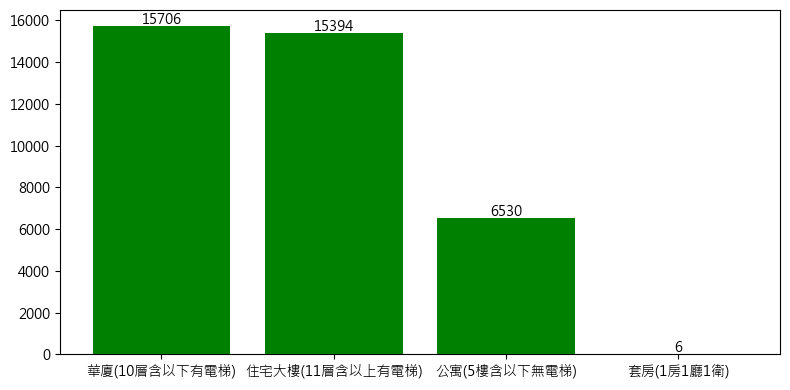

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
bars = ax.bar(df_realEstate1['建物型態'].unique(), df_realEstate1['建物型態'].value_counts(), color='green')

for bar in bars:
    yval = bar.get_height()  # 獲取每個條形的高度，即數量
    ax.text(bar.get_x() + bar.get_width() / 2, yval - 100, str(int(yval)), ha='center', va='bottom', fontsize=10)

plt.tight_layout()

### 2. 刪除欄位

刪除目前用不到的欄位。

In [8]:
# 刪除欄位
df_realEstate2 = df_realEstate1.drop(columns=['交易標的', '土地位置建物門牌', '土地面積平方公尺', '都市土地使用分區', '非都市土地使用分區', '非都市土地使用編定', 
                                              '租賃筆棟數', '主要用途', '主要建材', '單價元平方公尺', '車位類別', '車位總額元', '備註', '編號', '出租型態', '租賃住宅服務', '附屬設備'])
df_realEstate2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37636 entries, 0 to 37635
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   鄉鎮市區       37636 non-null  object
 1   租賃年月日      37636 non-null  object
 2   租賃層次       37636 non-null  object
 3   總樓層數       37636 non-null  object
 4   建物型態       37636 non-null  object
 5   建築完成年月     36333 non-null  object
 6   建物總面積平方公尺  37636 non-null  object
 7   建物現況格局-房   37636 non-null  object
 8   建物現況格局-廳   37636 non-null  object
 9   建物現況格局-衛   37636 non-null  object
 10  建物現況格局-隔間  37636 non-null  object
 11  有無管理組織     37636 non-null  object
 12  有無附傢俱      37636 non-null  object
 13  總額元        37636 non-null  object
 14  車位面積平方公尺   37636 non-null  object
 15  有無管理員      37604 non-null  object
 16  租賃期間       37604 non-null  object
 17  有無電梯       37604 non-null  object
 18  縣市         37636 non-null  object
 19  季別         37636 non-null  object
dtypes: object(20)
memory usage: 

### 3. 特徵轉換

In [9]:
# 進行數字轉換
df_realEstate2['建物現況格局-廳'] = df_realEstate2['建物現況格局-廳'].astype(int)
df_realEstate2['建物現況格局-房'] = df_realEstate2['建物現況格局-房'].astype(int)
df_realEstate2['建物現況格局-衛'] = df_realEstate2['建物現況格局-衛'].astype(int)
df_realEstate2['總額元'] = df_realEstate2['總額元'].astype(float)
df_realEstate2['車位'] = (df_realEstate2["車位面積平方公尺"].astype(float) > 0).astype(int)
df_realEstate2['租賃年份'] = df_realEstate2['租賃年月日'].astype(str).str[:-4].astype(int) + 1911
df_realEstate2['建築完成年份'] = df_realEstate2['建築完成年月'].str[:3].astype(float) + 1911

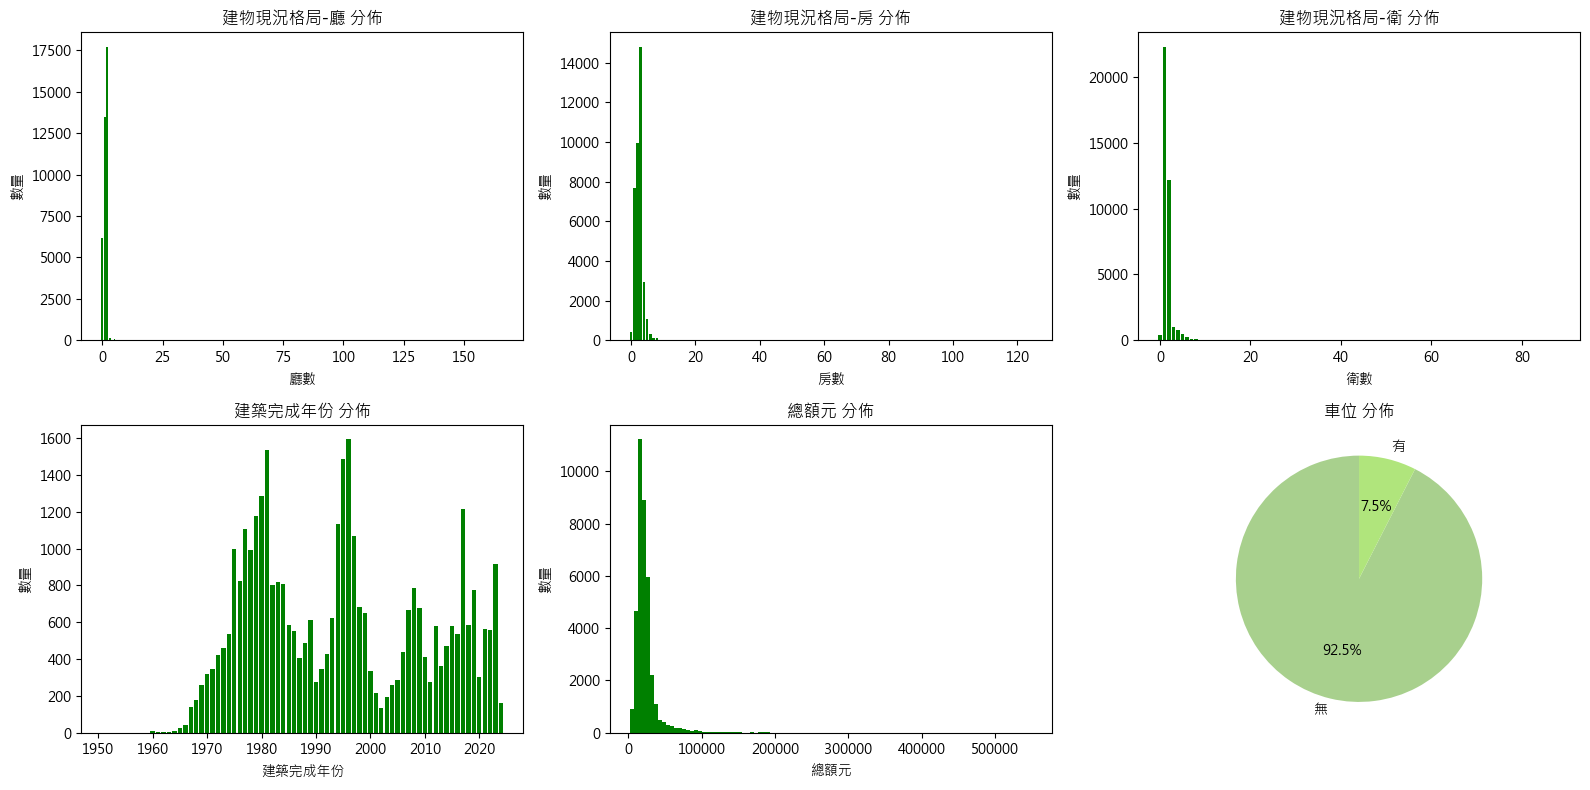

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# 直條圖：建物現況格局-廳
axs[0,0].bar(df_realEstate2['建物現況格局-廳'].value_counts().index, df_realEstate2['建物現況格局-廳'].value_counts(), color='green')
axs[0,0].set_title('建物現況格局-廳 分佈')
axs[0,0].set_xlabel('廳數')
axs[0,0].set_ylabel('數量')

# 直條圖：建物現況格局-房
axs[0,1].bar(df_realEstate2['建物現況格局-房'].value_counts().index, df_realEstate2['建物現況格局-房'].value_counts(), color='green')
axs[0,1].set_title('建物現況格局-房 分佈')
axs[0,1].set_xlabel('房數')
axs[0,1].set_ylabel('數量')

# 直條圖：建物現況格局-衛
axs[0,2].bar(df_realEstate2['建物現況格局-衛'].value_counts().index, df_realEstate2['建物現況格局-衛'].value_counts(), color='green')
axs[0,2].set_title('建物現況格局-衛 分佈')
axs[0,2].set_xlabel('衛數')
axs[0,2].set_ylabel('數量')

# 直條圖：建築完成年份
axs[1, 0].bar(df_realEstate2['建築完成年份'].value_counts().index, df_realEstate2['建築完成年份'].value_counts(), color='green')
axs[1, 0].set_title('建築完成年份 分佈')
axs[1, 0].set_xlabel('建築完成年份')
axs[1, 0].set_ylabel('數量')

# 直方圖：總額元
axs[1, 1].hist(df_realEstate2['總額元'], bins=100, color='green')
axs[1, 1].set_title('總額元 分佈')
axs[1, 1].set_xlabel('總額元')
axs[1, 1].set_ylabel('數量')

# 圓餅圖：車位
labels=df_realEstate2['車位'].value_counts().index.map({1: '有', 0: '無'})
axs[1, 2].pie(df_realEstate2['車位'].value_counts(), labels=labels, 
              autopct='%1.1f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[1, 2].set_title('車位 分佈')


plt.tight_layout()
plt.show()

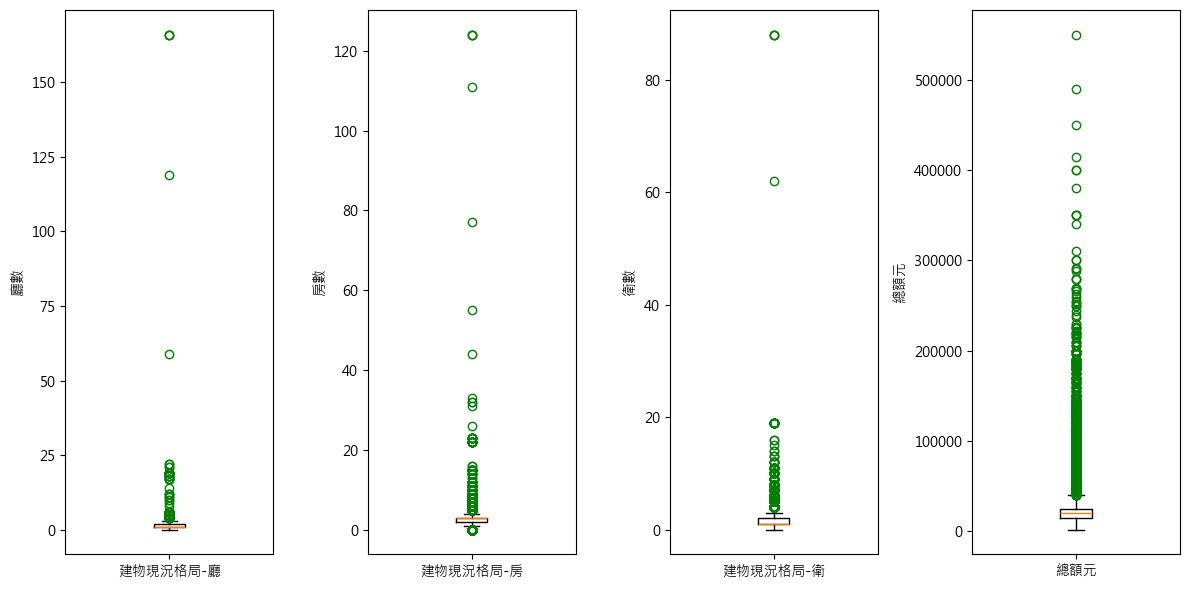

In [11]:
# 離群值檢測
fig, axs = plt.subplots(1, 4, figsize=(12, 6))
axs[0].boxplot(df_realEstate2['建物現況格局-廳'], flierprops=dict(markeredgecolor='green'))
axs[0].set_ylabel('廳數')
axs[0].set_xticklabels(['建物現況格局-廳'])

axs[1].boxplot(df_realEstate2['建物現況格局-房'], flierprops=dict(markeredgecolor='green'))
axs[1].set_ylabel('房數')
axs[1].set_xticklabels(['建物現況格局-房'])

axs[2].boxplot(df_realEstate2['建物現況格局-衛'], flierprops=dict(markeredgecolor='green'))
axs[2].set_ylabel('衛數')
axs[2].set_xticklabels(['建物現況格局-衛'])

axs[3].boxplot(df_realEstate2['總額元'], flierprops=dict(markeredgecolor='green'))
axs[3].set_ylabel('總額元')
axs[3].set_xticklabels(['總額元'])
plt.tight_layout()
plt.show()

### 4. 屋齡

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 67. 70. 73. nan]


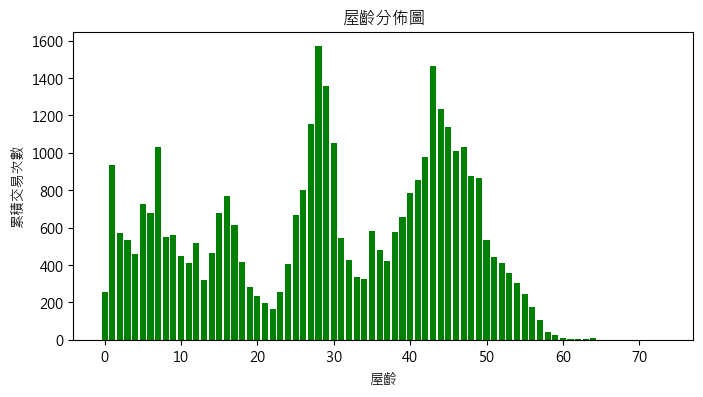

In [12]:
# 建立年份 Dataframe
a = df_realEstate2['租賃年份']
b = df_realEstate2['建築完成年份']
c = df_realEstate2['租賃年月日']
d = df_realEstate2['建築完成年月']

df_year = pd.concat([a,b,c,d], axis=1)
df_year = pd.DataFrame(df_year, columns=['租賃年份', '建築完成年份','租賃年月日','建築完成年月'])
df_year['屋齡'] = df_year['租賃年份'] - df_year['建築完成年份']
print(np.sort(df_year['屋齡'].unique()))
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(np.sort(df_year['屋齡'].unique())[:-1], df_year['屋齡'].value_counts().sort_index(), color='green')
ax.set_xlabel('屋齡')
ax.set_ylabel('累積交易次數')
ax.set_title('屋齡分佈圖')
plt.show()


- 屋齡大於 60 年交易與建築完成日期應無誤；若屋齡小於 0 年則為交易年月日有誤導致，應予以刪除。

In [13]:
# 確認年份是否有異常值
filtered_data = df_year[(df_year['屋齡'] > 60) | (df_year['屋齡'] == 0)]
sorted_data = filtered_data.sort_values(by = '屋齡', ascending = True)  
print('異常檢測：\n', sorted_data)

# 新增屋齡欄位並刪除異常值
df_realEstate2['屋齡'] = df_realEstate2['租賃年份'] - df_realEstate2['建築完成年份']
df_realEstate2 = df_realEstate2[df_realEstate2['屋齡'] > 0]


異常檢測：
        租賃年份  建築完成年份    租賃年月日   建築完成年月    屋齡
180    2023  2023.0  1121110  1120711   0.0
29926  2024  2024.0  1131015  1130327   0.0
29997  2024  2024.0  1130927  1130219   0.0
30043  2024  2024.0  1131013  1130116   0.0
30158  2024  2024.0  1131014  1130301   0.0
...     ...     ...      ...      ...   ...
18262  2024  1960.0  1130727  0491022  64.0
13459  2024  1960.0  1130410  0491005  64.0
17232  2024  1957.0  1130620  0460115  67.0
36553  2024  1954.0  1131029  0431207  70.0
16202  2024  1951.0  1130503  0401105  73.0

[279 rows x 5 columns]


### 5. 租賃層次

In [14]:
# 將欄位「租賃層次」的中文轉換成數字
df_realEstate2['租賃層次'] = df_realEstate2['租賃層次'].str.replace('層', '')
df_realEstate2['租賃層次'] = df_realEstate2['租賃層次'].astype(str)
layers = {
    '一': 1, '二': 2, '三': 3, '四': 4, '五': 5, '六': 6, '七': 7, '八': 8, '九': 9,'十':10
}

def convert_to_num(layer):
    if layer == '見其他登記事項' or '地' in layer :
        return None
    else:
        if len(layer[:-1]) == 2:
            num = layers.get(layer[0]) * 10 + layers.get(layer[-1])
            return num
        elif len(layer[:-1]) == 1:
            num = 10 + layers.get(layer[-1])
            return num
        else:
            num = layers.get(layer)
            return num
            
df_realEstate2['租賃層次'] = df_realEstate2['租賃層次'].apply(convert_to_num)
df_realEstate2 = df_realEstate2.dropna(subset=['租賃層次'])
df_realEstate2['租賃層次'].head()

0     6.0
1    13.0
2    10.0
3    14.0
4     6.0
Name: 租賃層次, dtype: float64

In [15]:
# 將層數轉為數字以便做分類
df_realEstate2['低樓層'] = df_realEstate2['租賃層次'].apply(lambda item: 1 <= item <= 5).astype(int)
df_realEstate2['中樓層'] = df_realEstate2['租賃層次'].apply(lambda item: 6 <= item <= 10).astype(int)
df_realEstate2['高樓層'] = df_realEstate2['租賃層次'].apply(lambda item: 11 <= item <= 15).astype(int)
df_realEstate2['超高樓層'] = df_realEstate2['租賃層次'].apply(lambda item: item >= 16).astype(int)
df_realEstate2['中樓層'].head()

0    1
1    0
2    1
3    0
4    1
Name: 中樓層, dtype: int32

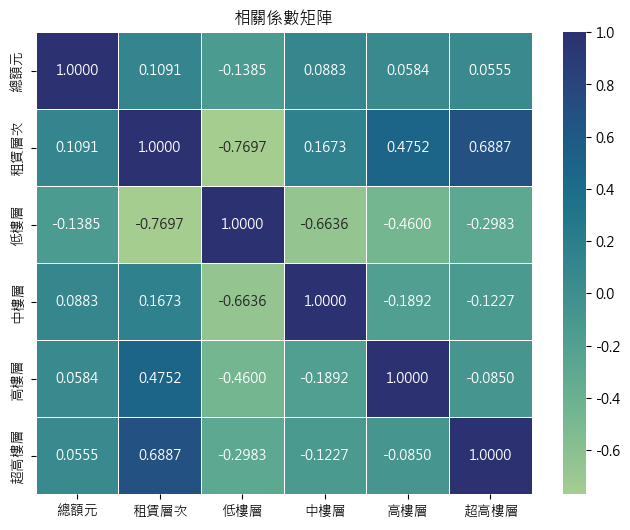

In [16]:
corr_matrix = df_realEstate2[['總額元', '租賃層次', '低樓層', '中樓層', '高樓層', '超高樓層']].corr()

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='crest', fmt=".4f", linewidths=0.5)
ax.set_title('相關係數矩陣')
plt.show()

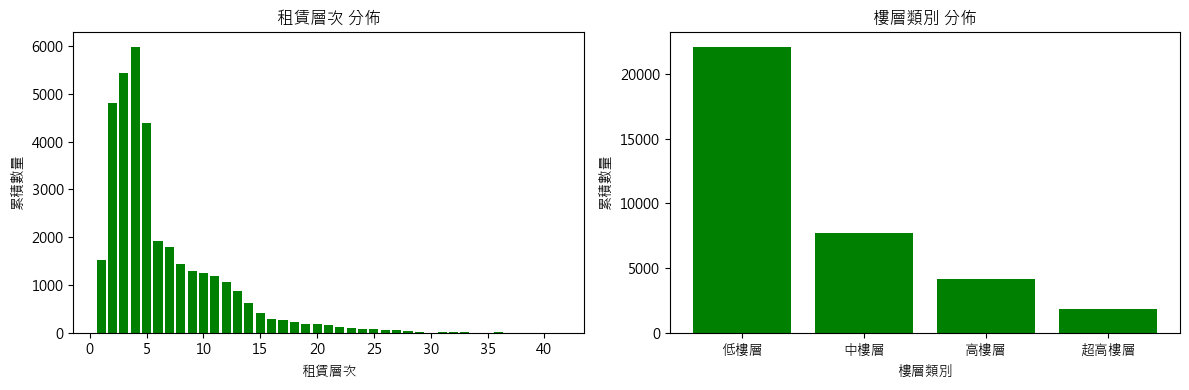

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].bar(df_realEstate2['租賃層次'].value_counts().index, df_realEstate2['租賃層次'].value_counts(), color='green')
axs[0].set_xlabel('租賃層次')
axs[0].set_ylabel('累積數量')
axs[0].set_title('租賃層次 分佈')

floor_counts = df_realEstate2[['低樓層', '中樓層', '高樓層', '超高樓層']].sum()
axs[1].bar(floor_counts.index, floor_counts.values, color='green')
axs[1].set_xlabel('樓層類別')
axs[1].set_ylabel('累積數量')
axs[1].set_title('樓層類別 分佈')

plt.tight_layout()
plt.show()

### 6. 虛擬變數轉換

In [18]:
df_realEstate2['建物現況格局-隔間'] = df_realEstate2['建物現況格局-隔間'].apply(lambda row: 1 if row == '有' else 0)
df_realEstate2['有無附傢俱'] = df_realEstate2['有無附傢俱'].apply(lambda row: 1 if row == '有' else 0)
df_realEstate2['有無管理員'] = df_realEstate2['有無管理員'].apply(lambda row: 1 if row == '有' else 0)
df_realEstate2['有無管理組織'] = df_realEstate2['有無管理組織'].apply(lambda row: 1 if row == '有' else 0)

#根據建物型態填充空值
df_realEstate2['有無電梯'] = df_realEstate2.apply(lambda row: '無' if pd.isna(row['有無電梯']) and row['建物型態'] == '公寓(5樓含以下無電梯)' else '有', axis=1)
df_realEstate2['有無電梯'] = df_realEstate2['有無電梯'].apply(lambda row: 1 if row == '有' else 0)
df_realEstate2['有無電梯'].head()

0    1
1    1
2    1
3    1
4    1
Name: 有無電梯, dtype: int64

- 「有無電梯」與「建物型態」結果相斥，以「建物型態」結果代替「有無電梯」的值。

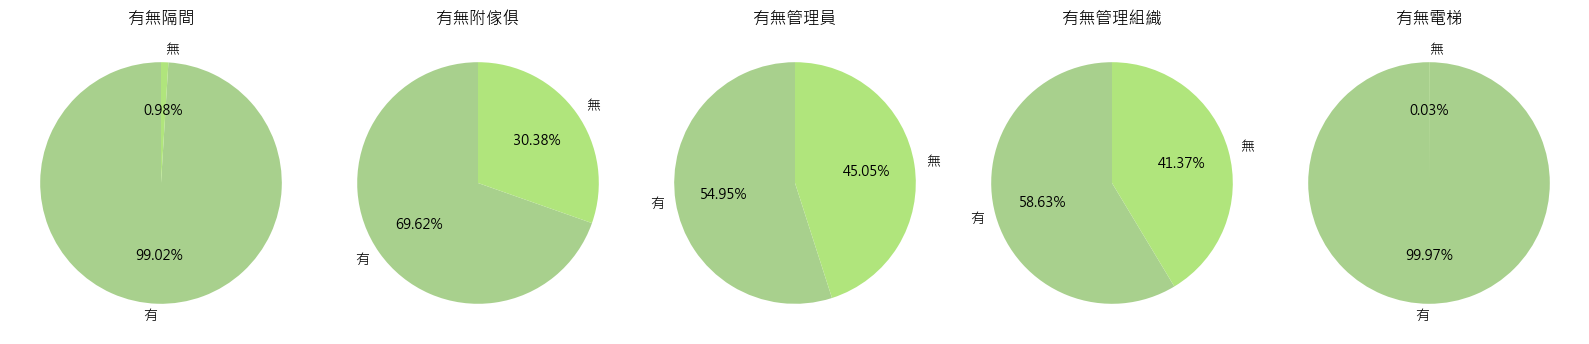

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(16, 4))

label1=df_realEstate2['建物現況格局-隔間'].value_counts().index.map({1: '有', 0: '無'})
axs[0].pie(df_realEstate2['建物現況格局-隔間'].value_counts(), labels=label1, autopct='%1.2f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[0].set_title('有無隔間')

label2=df_realEstate2['有無附傢俱'].value_counts().index.map({1: '有', 0: '無'})
axs[1].pie(df_realEstate2['有無附傢俱'].value_counts(), labels=label2, autopct='%1.2f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[1].set_title('有無附傢俱')

label3=df_realEstate2['有無管理員'].value_counts().index.map({1: '有', 0: '無'})
axs[2].pie(df_realEstate2['有無管理員'].value_counts(), labels=label3, autopct='%1.2f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[2].set_title('有無管理員')

label4=df_realEstate2['有無管理組織'].value_counts().index.map({1: '有', 0: '無'})
axs[3].pie(df_realEstate2['有無管理組織'].value_counts(), labels=label4, autopct='%1.2f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[3].set_title('有無管理組織')

label5=df_realEstate2['有無電梯'].value_counts().index.map({1: '有', 0: '無'})
axs[4].pie(df_realEstate2['有無電梯'].value_counts(), labels=label5, autopct='%1.2f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[4].set_title('有無電梯')


plt.tight_layout()
plt.show()


### 7. 有無電梯 & 租賃期間

In [20]:
def elevator(row):
    if ((row['建物型態'] == '套房(1房1廳1衛)') & (row['有無電梯'] == 1)) | (row['建物型態'] == '住宅大樓(11層含以上有電梯)') | (row['建物型態'] == '華廈(10層含以下有電梯)'):
        return 1
    else: 
        return 0
df_realEstate2['有無電梯'] = df_realEstate2.apply(elevator, axis=1)
df_realEstate2['有無電梯'].value_counts()

有無電梯
1    21862
0    13992
Name: count, dtype: int64

In [21]:
df_realEstate3 = df_realEstate2.dropna(subset='租賃期間')

def convert_minguo_to_gregorian(roc_date):
    roc_year = int(roc_date[:3])  # 民國年（前3位）
    month_day = roc_date[3:]  # 月日部分（後面部分）
    gregorian_year = roc_year + 1911  # 民國轉西元：加 1911
    return f"{gregorian_year}{month_day}"

# 計算租賃期間的間距
def calculate_period(row):
    start_date, end_date = row.split('~')
    
    # 轉換為西元日期
    start_date = convert_minguo_to_gregorian(start_date)
    end_date = convert_minguo_to_gregorian(end_date)
    
    # 轉換為 datetime 格式
    start_date = datetime.strptime(start_date, "%Y%m%d")
    end_date = datetime.strptime(end_date, "%Y%m%d")
    
    # 計算期間差距（天數）
    return (end_date - start_date).days // 30

df_realEstate3.loc[:, '租賃期間'] = df_realEstate3['租賃期間'].apply(calculate_period)
df_realEstate3['租賃期間'].value_counts()

租賃期間
12     28494
24      2729
36      1867
11       508
6        206
       ...  
71         1
74         1
182        1
55         1
67         1
Name: count, Length: 77, dtype: int64

租賃期間
12     28494
24      2729
36      1867
11       508
6        206
       ...  
71         1
74         1
182        1
55         1
67         1
Name: count, Length: 77, dtype: int64


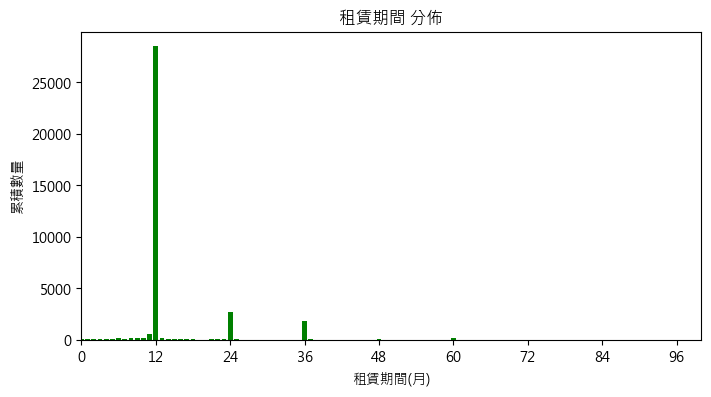

In [22]:
print(df_realEstate3['租賃期間'].value_counts())
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.bar(df_realEstate3['租賃期間'].value_counts().index, df_realEstate3['租賃期間'].value_counts(), color='green')
ax.set_xlabel('租賃期間(月)')
ax.set_ylabel('累積數量')
ax.set_xlim(0, 100)
ax.set_xticks(range(0, 100, 12))
ax.set_title('租賃期間 分佈')
plt.show()

### 8. One-hot encoding

In [23]:
#欄位「鄉鎮市區」改成 dummy 變數
df_realEstate3 = pd.get_dummies(df_realEstate3, columns = ['鄉鎮市區'], 
                               prefix = '鄉鎮市區',   # 新建虛擬變數的名稱前綴
                               dummy_na = False,      # 如果設為 True，則會為缺失值（NaN）創建一個虛擬變數列
                               drop_first = False)    # 如果設為 True，會刪除每個虛擬變數的第一個類別值

#欄位「縣市」改成 dummy 變數
df_realEstate3 = pd.get_dummies(df_realEstate3, columns = ['縣市'], prefix = '縣市', dummy_na = False, drop_first = False)    

# 以「縣市_新北市」作為基準點，並刪除此欄位
df_realEstate3 = df_realEstate3.drop(['縣市_新北市'],axis = 1)

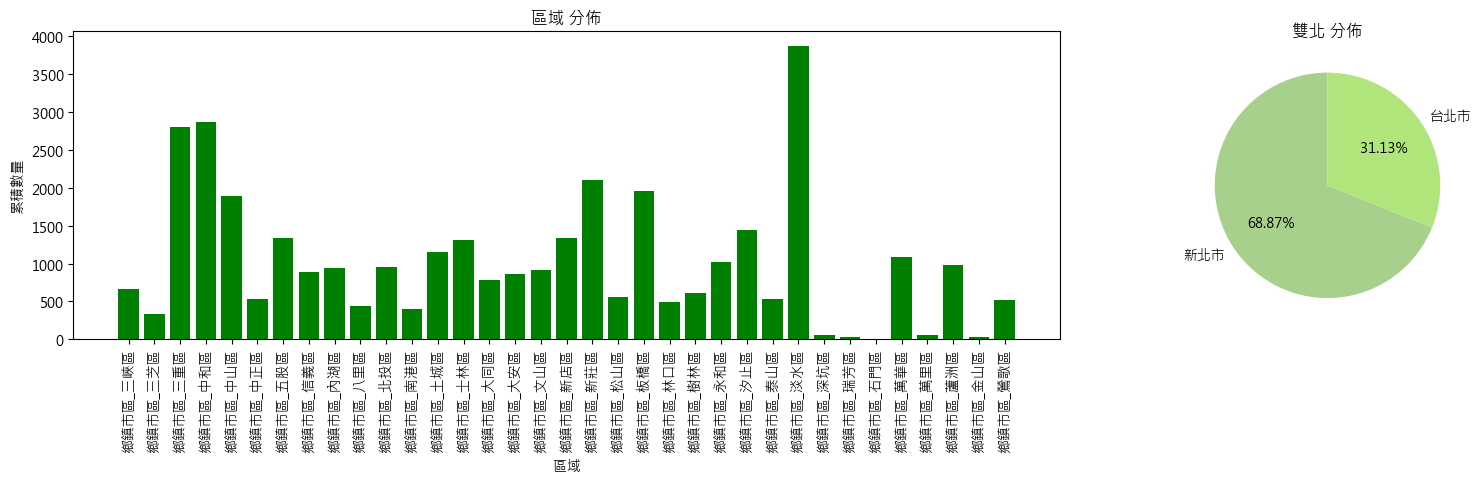

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [14, 4]})
dist_counts = df_realEstate3[df_realEstate3.columns[26:61]].sum()
axs[0].bar(dist_counts.index, dist_counts.values, color='green')
axs[0].set_xlabel('區域')
axs[0].set_ylabel('累積數量')
axs[0].set_title('區域 分佈')
axs[0].set_xticks(df_realEstate3.columns[26:61])
axs[0].set_xticklabels(df_realEstate3.columns[26:61], rotation=90)

label1=df_realEstate3['縣市_台北市'].value_counts().index.map({True: '台北市', False: '新北市'})
axs[1].pie(df_realEstate3['縣市_台北市'].value_counts(), labels=label1, autopct='%1.2f%%', startangle=90, colors= ['#a8d08d', '#b0e57c'])
axs[1].set_title('雙北 分佈')

plt.show()

### 9. 刪除變數 

In [25]:
df_realEstate4 = df_realEstate3.drop(columns= ['租賃年月日', '建物型態', '建築完成年月', '車位面積平方公尺', '租賃年份', '建築完成年份'])
df_realEstate4.head(1)

,租賃層次,總樓層數,建物總面積平方公尺,建物現況格局-房,建物現況格局-廳,建物現況格局-衛,建物現況格局-隔間,有無管理組織,有無附傢俱,總額元,有無管理員,租賃期間,有無電梯,季別,車位,屋齡,低樓層,中樓層,高樓層,超高樓層,鄉鎮市區_三峽區,鄉鎮市區_三芝區,鄉鎮市區_三重區,鄉鎮市區_中和區,鄉鎮市區_中山區,鄉鎮市區_中正區,鄉鎮市區_五股區,鄉鎮市區_信義區,鄉鎮市區_內湖區,鄉鎮市區_八里區,鄉鎮市區_北投區,鄉鎮市區_南港區,鄉鎮市區_土城區,鄉鎮市區_士林區,鄉鎮市區_大同區,鄉鎮市區_大安區,鄉鎮市區_文山區,鄉鎮市區_新店區,鄉鎮市區_新莊區,鄉鎮市區_松山區,鄉鎮市區_板橋區,鄉鎮市區_林口區,鄉鎮市區_樹林區,鄉鎮市區_永和區,鄉鎮市區_汐止區,鄉鎮市區_泰山區,鄉鎮市區_淡水區,鄉鎮市區_深坑區,鄉鎮市區_瑞芳區,鄉鎮市區_石門區,鄉鎮市區_萬華區,鄉鎮市區_萬里區,鄉鎮市區_蘆洲區,鄉鎮市區_金山區,鄉鎮市區_鶯歌區,縣市_台北市
0,6.0,7,121.69999999999999,2,2,2,1,1,1,59000.0,1,24,1,113S1,0,13.0,0,1,0,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


In [26]:
df_realEstate4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35823 entries, 0 to 37635
Data columns (total 56 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   租賃層次       35823 non-null  float64
 1   總樓層數       35823 non-null  object 
 2   建物總面積平方公尺  35823 non-null  object 
 3   建物現況格局-房   35823 non-null  int32  
 4   建物現況格局-廳   35823 non-null  int32  
 5   建物現況格局-衛   35823 non-null  int32  
 6   建物現況格局-隔間  35823 non-null  int64  
 7   有無管理組織     35823 non-null  int64  
 8   有無附傢俱      35823 non-null  int64  
 9   總額元        35823 non-null  float64
 10  有無管理員      35823 non-null  int64  
 11  租賃期間       35823 non-null  object 
 12  有無電梯       35823 non-null  int64  
 13  季別         35823 non-null  object 
 14  車位         35823 non-null  int32  
 15  屋齡         35823 non-null  float64
 16  低樓層        35823 non-null  int32  
 17  中樓層        35823 non-null  int32  
 18  高樓層        35823 non-null  int32  
 19  超高樓層       35823 non-null  int32  
 20  鄉鎮市區_三峽區   

### 10. 特徵轉換

In [27]:
df_realEstate4['總樓層數'] = df_realEstate4['總樓層數'].astype(int)
df_realEstate4['建物總面積平方公尺'] = df_realEstate4['建物總面積平方公尺'].astype(float)
df_realEstate4['租賃期間'] = df_realEstate4['租賃期間'].astype(int)

### 11. 目標變數

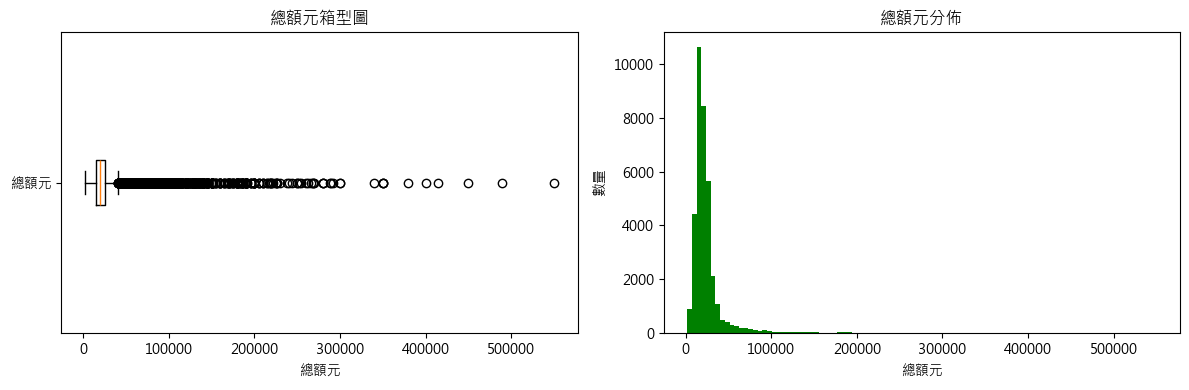

In [28]:
# 總額元箱型圖
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].boxplot(df_realEstate4['總額元'], vert=False)
axs[0].set_title('總額元箱型圖')
axs[0].set_xlabel('總額元')
axs[0].set_yticklabels(['總額元'])
axs[1].hist(df_realEstate4['總額元'], bins=100, color='green')
axs[1].set_title('總額元分佈')
axs[1].set_xlabel('總額元')
axs[1].set_ylabel('數量')
plt.tight_layout()

plt.show()

In [29]:
# 找出離群值: 四分位距
Q1 = df_realEstate4['總額元'].quantile(0.25)  
Q3 = df_realEstate4['總額元'].quantile(0.75) 
IQR = Q3 - Q1  
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_realEstate4[(df_realEstate4['總額元'] < lower_bound) | (df_realEstate4['總額元'] > upper_bound)]
print('1st 四分位距離群值：',outliers['總額元'].sort_values().iloc[0])
print('四分位距離群值佔比：', round(len(outliers) / len(df_realEstate4), 4))
df_realEstate5 = df_realEstate4[(df_realEstate4['總額元'] >= lower_bound) & (df_realEstate4['總額元'] <= upper_bound)]

# 找出離群值: 標準差
df_realEstate6 = df_realEstate4.copy()
df_realEstate6['Z分數'] = np.abs(stats.zscore(df_realEstate6['總額元']))
outliers = df_realEstate6[df_realEstate6['Z分數'] > 3]
df_realEstate6 = df_realEstate6[df_realEstate6['Z分數'] <= 3]
print('1st 標準差 離群值：',outliers['總額元'].sort_values().iloc[0])
print('標準差 離群值佔比：', round(len(outliers) / len(df_realEstate4), 4))


1st 四分位距離群值： 41265.0
四分位距離群值佔比： 0.0708
1st 標準差 離群值： 81600.0
標準差 離群值佔比： 0.0174


- 刪去離群值後模型訓練的結果並不好。

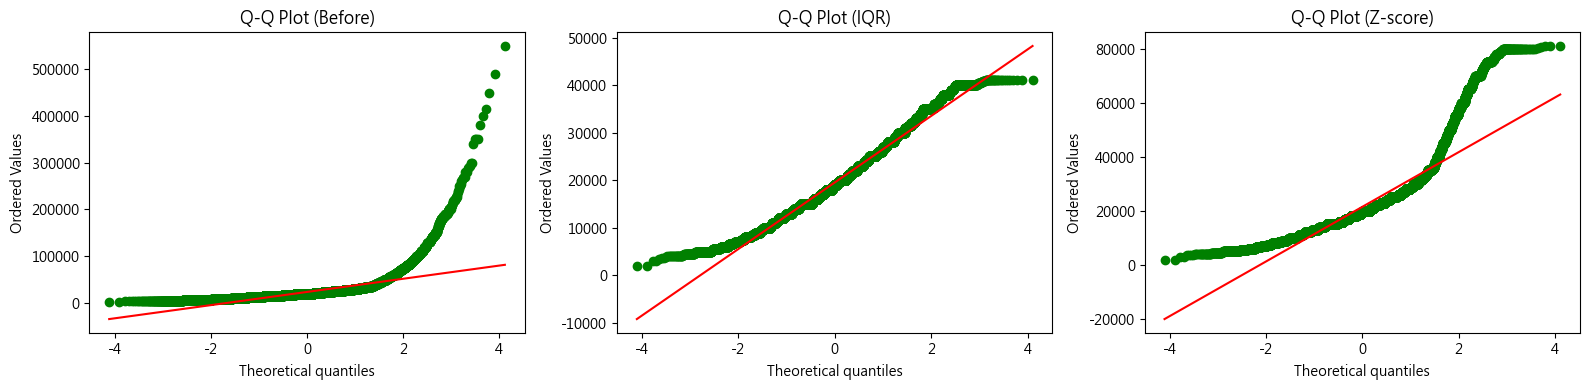

In [30]:
# 常態性檢驗
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

stats.probplot(df_realEstate4['總額元'], dist="norm", plot=axs[0])
axs[0].set_title('Q-Q Plot (Before)')
axs[0].get_lines()[0].set_markeredgecolor('green') 
axs[0].get_lines()[0].set_markerfacecolor('green') 

stats.probplot(df_realEstate5['總額元'], dist="norm", plot=axs[1])
axs[1].set_title('Q-Q Plot (IQR)')
axs[1].get_lines()[0].set_markeredgecolor('green') 
axs[1].get_lines()[0].set_markerfacecolor('green') 

stats.probplot(df_realEstate6['總額元'], dist="norm", plot=axs[2])
axs[2].set_title('Q-Q Plot (Z-score)')
axs[2].get_lines()[0].set_markeredgecolor('green') 
axs[2].get_lines()[0].set_markerfacecolor('green') 

plt.tight_layout()
plt.show()

## 三、資料視覺化

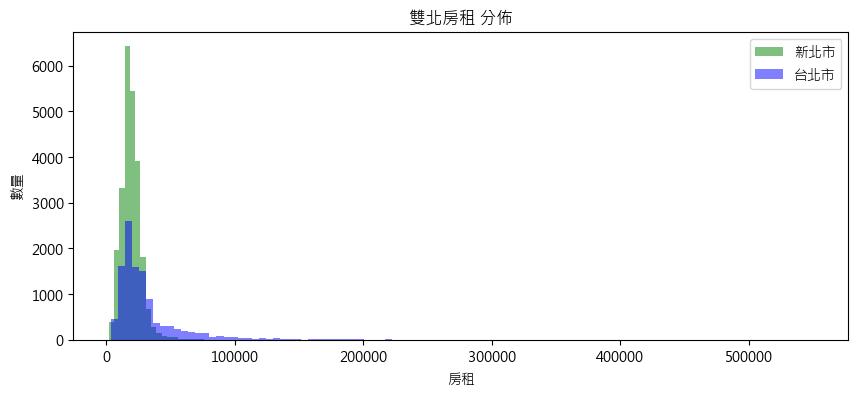

In [31]:
# 雙北總額元分佈
grouped = df_realEstate4.groupby('縣市_台北市')

fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for name, group in grouped:
    if name == 1:  # '縣市_台北市' 是 1 代表台北市
        ax.hist(group['總額元'], bins=100, alpha=0.5, label='台北市', color='blue')
        ax.set_title('雙北房租 分佈')
        ax.set_xlabel('房租')
        ax.set_ylabel('數量')
        ax.legend()
    else:
        ax.hist(group['總額元'], bins=100, alpha=0.5, label='新北市', color='green')

plt.show()

- 季別作為分層抽樣使用。

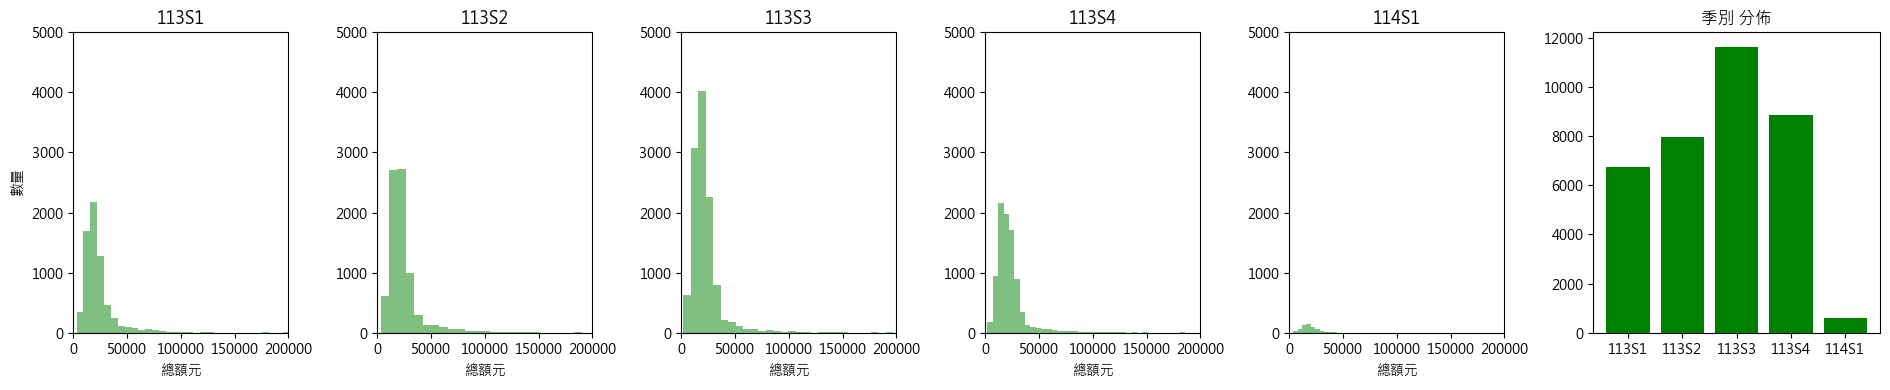

In [32]:
# 季別總額元分佈
season_groups = df_realEstate4.groupby('季別')

fig, axs = plt.subplots(1, 6, figsize=(19, 4), gridspec_kw={'width_ratios': [3, 3, 3, 3, 3, 4]})

for i, (season, group) in enumerate(season_groups):
    axs[i].hist(group['總額元'], bins=70, alpha=0.5, label=season, color='green')
    axs[i].set_title(f'{season}')
    axs[i].set_xlabel('總額元')
    axs[i].set_xlim(0, 200000)
    axs[i].set_ylim(0, 5000)   

axs[0].set_ylabel('數量')
axs[5].bar(df_realEstate4['季別'].unique(), df_realEstate4['季別'].value_counts().sort_index(), color='green')
axs[5].set_title('季別 分佈')
plt.tight_layout()
plt.show()

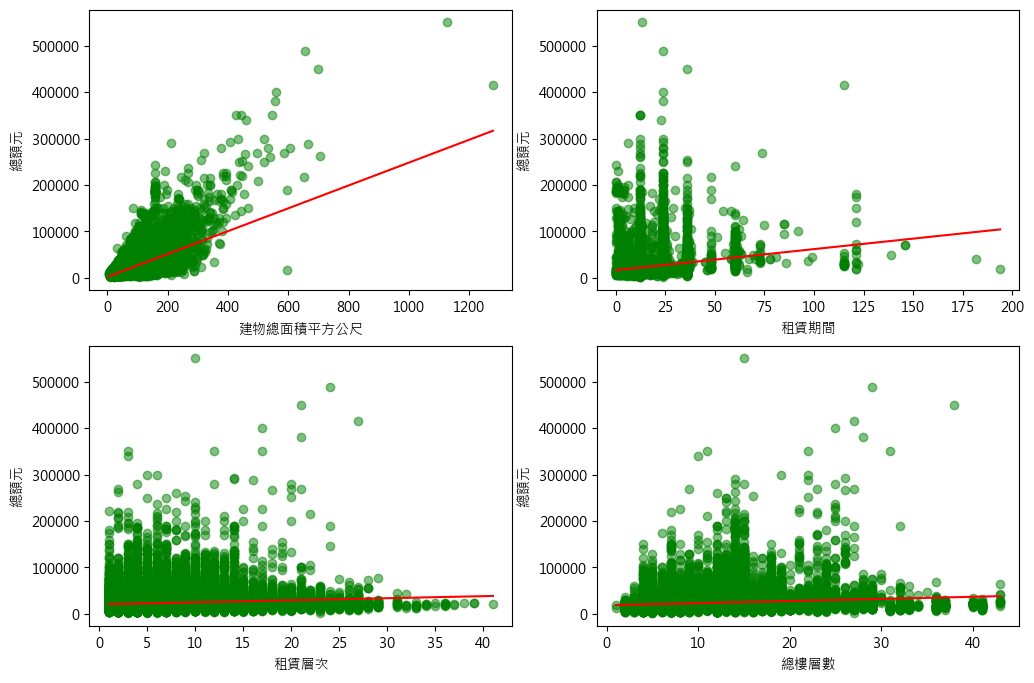

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# 建物總面積平方公尺 vs. 總額元
coef = np.polyfit(df_realEstate4['建物總面積平方公尺'], df_realEstate4['總額元'], 1)  # 1 表示一階多項式（線性回歸）
poly1d_fn = np.poly1d(coef) # 產生回歸方程
x_range = np.linspace(min(df_realEstate4['建物總面積平方公尺']), max(df_realEstate4['建物總面積平方公尺']), 100)

axs[0, 0].scatter(df_realEstate4['建物總面積平方公尺'], df_realEstate4['總額元'], color='green', alpha=0.5)
axs[0, 0].set_xlabel('建物總面積平方公尺')
axs[0, 0].set_ylabel('總額元')
axs[0, 0].plot(x_range, poly1d_fn(x_range), color='red', label="回歸線")

#  租賃期間 vs. 總額元
coef = np.polyfit(df_realEstate4['租賃期間'], df_realEstate4['總額元'], 1) 
poly1d_fn = np.poly1d(coef) 
x_range = np.linspace(min(df_realEstate4['租賃期間']), max(df_realEstate4['租賃期間']), 100)

axs[0, 1].scatter(df_realEstate4['租賃期間'], df_realEstate4['總額元'], color='green', alpha=0.5)
axs[0, 1].set_xlabel('租賃期間')
axs[0, 1].set_ylabel('總額元')
axs[0, 1].plot(x_range, poly1d_fn(x_range), color='red', label="回歸線")

#  租賃層次 vs. 總額元
coef = np.polyfit(df_realEstate4['租賃層次'], df_realEstate4['總額元'], 1)  
poly1d_fn = np.poly1d(coef) 
x_range = np.linspace(min(df_realEstate4['租賃層次']), max(df_realEstate4['租賃層次']), 100)

axs[1, 0].scatter(df_realEstate4['租賃層次'], df_realEstate4['總額元'], color='green', alpha=0.5)
axs[1, 0].set_xlabel('租賃層次')
axs[1, 0].set_ylabel('總額元')
axs[1, 0].plot(x_range, poly1d_fn(x_range), color='red', label="回歸線")

# 總樓層數 vs. 總額元
coef = np.polyfit(df_realEstate4['總樓層數'], df_realEstate4['總額元'], 1) 
poly1d_fn = np.poly1d(coef) 
x_range = np.linspace(min(df_realEstate4['總樓層數']), max(df_realEstate4['總樓層數']), 100)

axs[1, 1].scatter(df_realEstate4['總樓層數'], df_realEstate4['總額元'], color='green', alpha=0.5)
axs[1, 1].set_xlabel('總樓層數')
axs[1, 1].set_ylabel('總額元')
axs[1, 1].plot(x_range, poly1d_fn(x_range), color='red', label="回歸線")

plt.show()

## 四、匯出資料

In [34]:
df_realEstate4.to_csv('RealEstate.csv', index = False, sep = ',',encoding = 'big5')  
